In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('all-dataset.csv')

# Display basic info
print("Dataset Info:")
print(df.info())
print("\nDataset Shape:", df.shape)
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 11 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Provinsi                                                          505 non-null    object 
 1   Kabupaten/Kota                                                    505 non-null    object 
 2   Persentase Penduduk Miskin (P0)                                   505 non-null    float64
 3   Rata-rata Lama Sekolah                                            505 non-null    float64
 4   Pengeluaran per Kapita                                            505 non-null    int64  
 5   Umur Harapan Hidup (UHH)                                          505 non-null    float64
 6   Indeks Pembangunan Manusia (IPM)                                  505 non-null    float64
 7   Tingkat Pengangguran 

# Heatmap

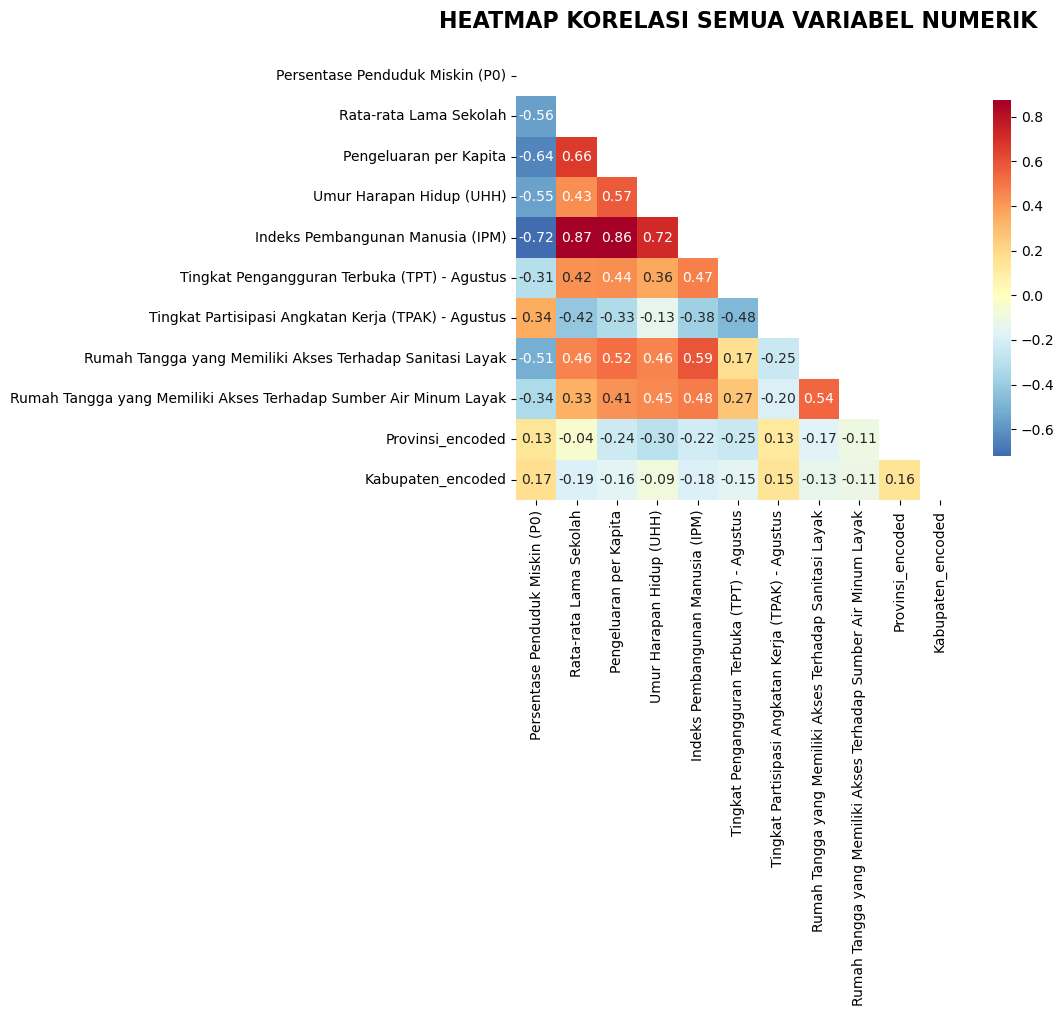

In [27]:
plt.figure(figsize=(12, 10))
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Calculate correlation matrix
correlation_matrix = df[numeric_cols].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot heatmap
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdYlBu_r', 
            center=0,
            fmt='.2f',
            square=True,
            cbar_kws={"shrink": .8})
plt.title('HEATMAP KORELASI SEMUA VARIABEL NUMERIK', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [28]:
# Analisis korelasi dengan target
print("\nKORELASI DENGAN TARGET (Persentase Penduduk Miskin):")
correlation_with_target = df[numeric_cols].corr()[['Persentase Penduduk Miskin (P0)']].sort_values(
    'Persentase Penduduk Miskin (P0)', ascending=False)

print(correlation_with_target.round(4))


KORELASI DENGAN TARGET (Persentase Penduduk Miskin):
                                                    Persentase Penduduk Miskin (P0)
Persentase Penduduk Miskin (P0)                                              1.0000
Tingkat Partisipasi Angkatan Kerja (TPAK) - Agu...                           0.3449
Kabupaten_encoded                                                            0.1724
Provinsi_encoded                                                             0.1345
Tingkat Pengangguran Terbuka (TPT) - Agustus                                -0.3097
Rumah Tangga yang Memiliki Akses Terhadap Sumbe...                          -0.3384
Rumah Tangga yang Memiliki Akses Terhadap Sanit...                          -0.5146
Umur Harapan Hidup (UHH)                                                    -0.5509
Rata-rata Lama Sekolah                                                      -0.5587
Pengeluaran per Kapita                                                      -0.6423
Indeks Pembangunan Man

Text(0.5, 1.0, 'Distribusi Persentase Penduduk Miskin')

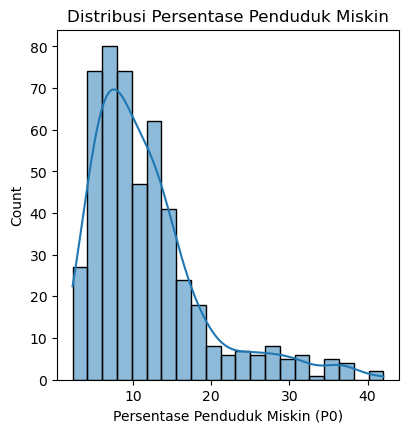

In [4]:
# Exploratory Data Analysis
plt.figure(figsize=(15, 10))

# Distribusi target variable
plt.subplot(2, 3, 1)
sns.histplot(df['Persentase Penduduk Miskin (P0)'], kde=True)
plt.title('Distribusi Persentase Penduduk Miskin')

# Preprocessing

In [10]:
# 1. Handling Categorical Variables
label_encoder_provinsi = LabelEncoder()
label_encoder_kabupaten = LabelEncoder()

df['Provinsi_encoded'] = label_encoder_provinsi.fit_transform(df['Provinsi'])
df['Kabupaten_encoded'] = label_encoder_kabupaten.fit_transform(df['Kabupaten/Kota'])

In [11]:
# 2. Feature Selection
features = ['Rata-rata Lama Sekolah', 'Pengeluaran per Kapita', 'Umur Harapan Hidup (UHH)',
           'Indeks Pembangunan Manusia (IPM)', 'Tingkat Pengangguran Terbuka (TPT) - Agustus',
           'Tingkat Partisipasi Angkatan Kerja (TPAK) - Agustus',
           'Rumah Tangga yang Memiliki Akses Terhadap Sanitasi Layak',
           'Rumah Tangga yang Memiliki Akses Terhadap Sumber Air Minum Layak',
           'Provinsi_encoded', 'Kabupaten_encoded']

X = df[features]
y = df['Persentase Penduduk Miskin (P0)']

print(f"Features used: {len(features)}")
print("Features:", features)

Features used: 10
Features: ['Rata-rata Lama Sekolah', 'Pengeluaran per Kapita', 'Umur Harapan Hidup (UHH)', 'Indeks Pembangunan Manusia (IPM)', 'Tingkat Pengangguran Terbuka (TPT) - Agustus', 'Tingkat Partisipasi Angkatan Kerja (TPAK) - Agustus', 'Rumah Tangga yang Memiliki Akses Terhadap Sanitasi Layak', 'Rumah Tangga yang Memiliki Akses Terhadap Sumber Air Minum Layak', 'Provinsi_encoded', 'Kabupaten_encoded']


In [12]:
# 3. Handling Outliers dengan IQR method
def handle_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Cap outliers instead of removing
            df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
            df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
    return df_clean


In [13]:
# Apply outlier handling
numeric_features = [f for f in features if 'encoded' not in f]
df_clean = handle_outliers_iqr(pd.concat([X, y], axis=1), numeric_features + ['Persentase Penduduk Miskin (P0)'])

X_clean = df_clean[features]
y_clean = df_clean['Persentase Penduduk Miskin (P0)']

# 4. Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)


In [29]:
# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_clean, test_size=0.2, random_state=42, shuffle=True
)

print(f"Data Splitting:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")


Data Splitting:
Training set: 404 samples
Test set: 101 samples
Number of features: 10


# Algoritma 1 : Linear Regression

In [30]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_train_lr = lr_model.predict(X_train)
y_pred_test_lr = lr_model.predict(X_test)

# Calculate metrics
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_pred_train_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
train_mae_lr = mean_absolute_error(y_train, y_pred_train_lr)
test_mae_lr = mean_absolute_error(y_test, y_pred_test_lr)
train_r2_lr = r2_score(y_train, y_pred_train_lr)
test_r2_lr = r2_score(y_test, y_pred_test_lr)

In [31]:
# Cross-validation
cv_scores_lr = cross_val_score(lr_model, X_scaled, y_clean, cv=5, scoring='r2')

print("📊 HASIL LINEAR REGRESSION:")
print(f"   R² Score Train:    {train_r2_lr:.4f}")
print(f"   R² Score Test:     {test_r2_lr:.4f}")
print(f"   R² Cross-Validation: {cv_scores_lr.mean():.4f} (±{cv_scores_lr.std() * 2:.4f})")
print(f"   RMSE Train:        {train_rmse_lr:.4f}")
print(f"   RMSE Test:         {test_rmse_lr:.4f}")
print(f"   MAE Train:         {train_mae_lr:.4f}")
print(f"   MAE Test:          {test_mae_lr:.4f}")

# Feature coefficients
print("\n📈 KOEFISIEN LINEAR REGRESSION:")
lr_coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_,
    'Absolute_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Absolute_Coefficient', ascending=False)

print(lr_coefficients.round(4))

📊 HASIL LINEAR REGRESSION:
   R² Score Train:    0.5083
   R² Score Test:     0.5766
   R² Cross-Validation: 0.0554 (±0.6266)
   RMSE Train:        4.1778
   RMSE Test:         4.2651
   MAE Train:         3.2755
   MAE Test:          3.3570

📈 KOEFISIEN LINEAR REGRESSION:
                                             Feature  Coefficient  \
1                             Pengeluaran per Kapita      -3.0339   
2                           Umur Harapan Hidup (UHH)      -1.8969   
5  Tingkat Partisipasi Angkatan Kerja (TPAK) - Ag...       0.9358   
6  Rumah Tangga yang Memiliki Akses Terhadap Sani...      -0.7591   
3                   Indeks Pembangunan Manusia (IPM)       0.5890   
8                                   Provinsi_encoded      -0.5648   
9                                  Kabupaten_encoded       0.5541   
7  Rumah Tangga yang Memiliki Akses Terhadap Sumb...       0.5523   
4       Tingkat Pengangguran Terbuka (TPT) - Agustus       0.3763   
0                             Rata-r

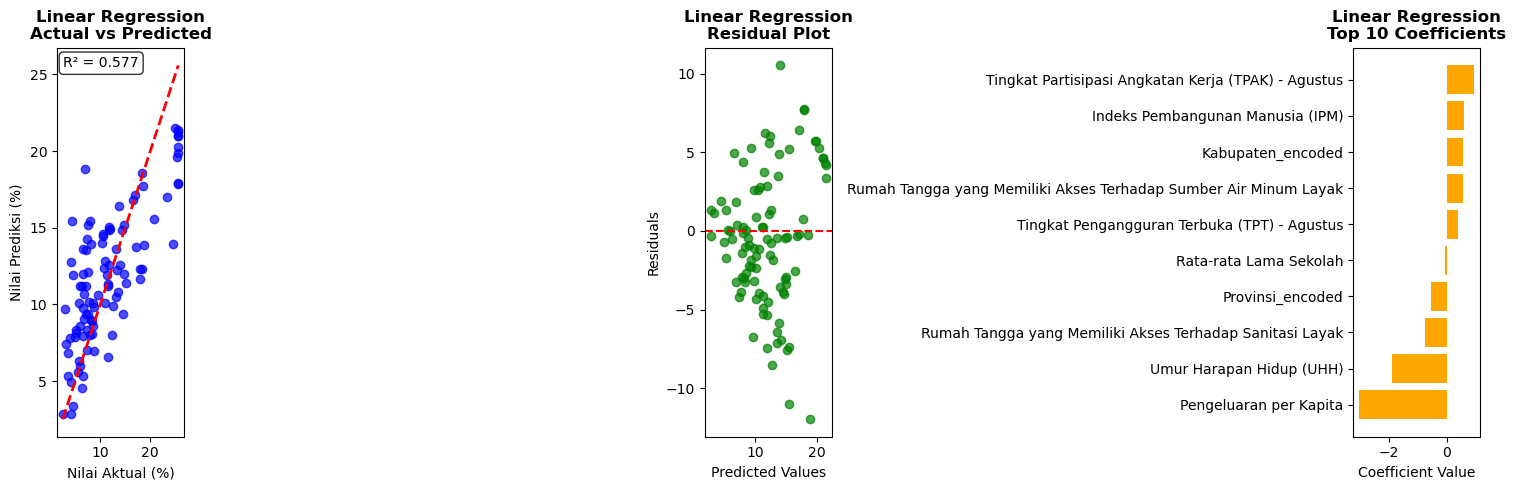

In [32]:
# Visualisasi Linear Regression
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_test_lr, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Nilai Aktual (%)')
plt.ylabel('Nilai Prediksi (%)')
plt.title('Linear Regression\nActual vs Predicted', fontweight='bold')
plt.text(0.05, 0.95, f'R² = {test_r2_lr:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.subplot(1, 3, 2)
residuals_lr = y_test - y_pred_test_lr
plt.scatter(y_pred_test_lr, residuals_lr, alpha=0.7, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Linear Regression\nResidual Plot', fontweight='bold')

plt.subplot(1, 3, 3)
# Top 10 coefficients
top_coeff = lr_coefficients.head(10).sort_values('Coefficient', ascending=True)
plt.barh(top_coeff['Feature'], top_coeff['Coefficient'], color='orange')
plt.title('Linear Regression\nTop 10 Coefficients', fontweight='bold')
plt.xlabel('Coefficient Value')

plt.tight_layout()
plt.show()


# Algoritma 2 : Random Forest

In [33]:
# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

# Calculate metrics
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
train_mae_rf = mean_absolute_error(y_train, y_pred_train_rf)
test_mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
train_r2_rf = r2_score(y_train, y_pred_train_rf)
test_r2_rf = r2_score(y_test, y_pred_test_rf)

In [34]:
# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X_scaled, y_clean, cv=5, scoring='r2')

print("📊 HASIL RANDOM FOREST:")
print(f"   R² Score Train:    {train_r2_rf:.4f}")
print(f"   R² Score Test:     {test_r2_rf:.4f}")
print(f"   R² Cross-Validation: {cv_scores_rf.mean():.4f} (±{cv_scores_rf.std() * 2:.4f})")
print(f"   RMSE Train:        {train_rmse_rf:.4f}")
print(f"   RMSE Test:         {test_rmse_rf:.4f}")
print(f"   MAE Train:         {train_mae_rf:.4f}")
print(f"   MAE Test:          {test_mae_rf:.4f}")

# Feature importance
print("\n📈 FEATURE IMPORTANCE RANDOM FOREST:")
rf_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(rf_importance.round(4))

📊 HASIL RANDOM FOREST:
   R² Score Train:    0.9027
   R² Score Test:     0.6812
   R² Cross-Validation: 0.2535 (±0.2201)
   RMSE Train:        1.8586
   RMSE Test:         3.7005
   MAE Train:         1.4167
   MAE Test:          2.7789

📈 FEATURE IMPORTANCE RANDOM FOREST:
                                             Feature  Importance
3                   Indeks Pembangunan Manusia (IPM)      0.4174
1                             Pengeluaran per Kapita      0.2107
8                                   Provinsi_encoded      0.0790
2                           Umur Harapan Hidup (UHH)      0.0662
9                                  Kabupaten_encoded      0.0474
5  Tingkat Partisipasi Angkatan Kerja (TPAK) - Ag...      0.0396
6  Rumah Tangga yang Memiliki Akses Terhadap Sani...      0.0394
0                             Rata-rata Lama Sekolah      0.0372
4       Tingkat Pengangguran Terbuka (TPT) - Agustus      0.0349
7  Rumah Tangga yang Memiliki Akses Terhadap Sumb...      0.0281


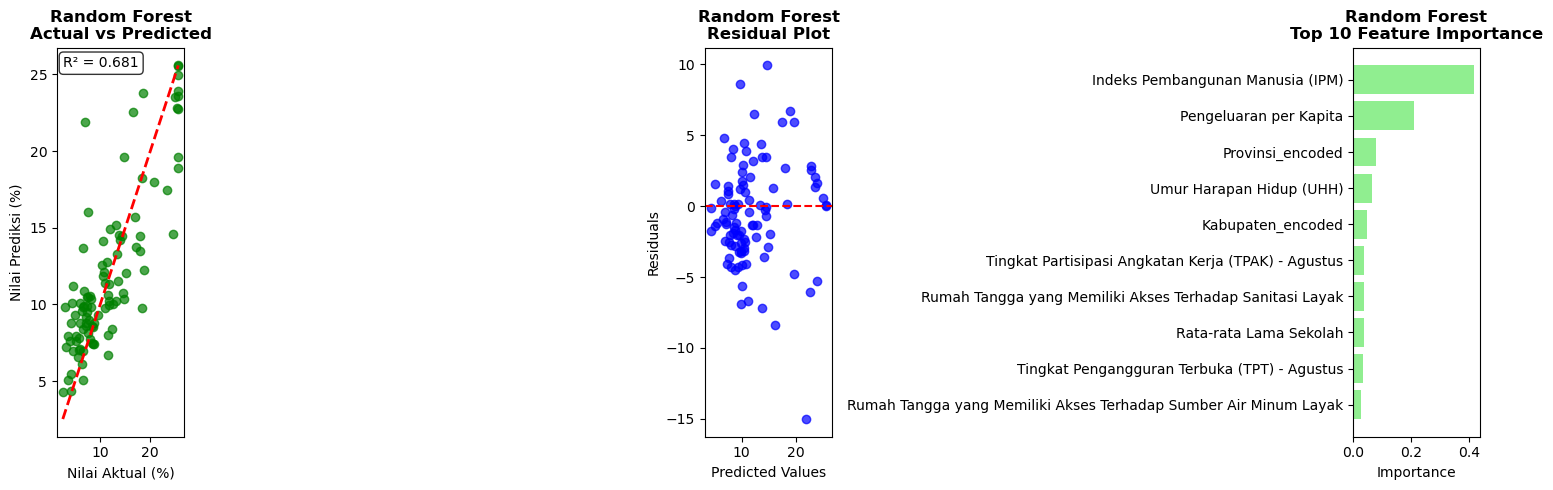

In [35]:
# Visualisasi Random Forest
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_test_rf, alpha=0.7, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Nilai Aktual (%)')
plt.ylabel('Nilai Prediksi (%)')
plt.title('Random Forest\nActual vs Predicted', fontweight='bold')
plt.text(0.05, 0.95, f'R² = {test_r2_rf:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.subplot(1, 3, 2)
residuals_rf = y_test - y_pred_test_rf
plt.scatter(y_pred_test_rf, residuals_rf, alpha=0.7, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Random Forest\nResidual Plot', fontweight='bold')

plt.subplot(1, 3, 3)
# Top 10 features
top_features_rf = rf_importance.head(10).sort_values('Importance', ascending=True)
plt.barh(top_features_rf['Feature'], top_features_rf['Importance'], color='lightgreen')
plt.title('Random Forest\nTop 10 Feature Importance', fontweight='bold')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

# Algoritma 3 : Gradient Boosting

In [36]:
# Train Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train, y_train)

# Predictions
y_pred_train_gb = gb_model.predict(X_train)
y_pred_test_gb = gb_model.predict(X_test)

# Calculate metrics
train_rmse_gb = np.sqrt(mean_squared_error(y_train, y_pred_train_gb))
test_rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_test_gb))
train_mae_gb = mean_absolute_error(y_train, y_pred_train_gb)
test_mae_gb = mean_absolute_error(y_test, y_pred_test_gb)
train_r2_gb = r2_score(y_train, y_pred_train_gb)
test_r2_gb = r2_score(y_test, y_pred_test_gb)

In [37]:
# Cross-validation
cv_scores_gb = cross_val_score(gb_model, X_scaled, y_clean, cv=5, scoring='r2')

print("📊 HASIL GRADIENT BOOSTING:")
print(f"   R² Score Train:    {train_r2_gb:.4f}")
print(f"   R² Score Test:     {test_r2_gb:.4f}")
print(f"   R² Cross-Validation: {cv_scores_gb.mean():.4f} (±{cv_scores_gb.std() * 2:.4f})")
print(f"   RMSE Train:        {train_rmse_gb:.4f}")
print(f"   RMSE Test:         {test_rmse_gb:.4f}")
print(f"   MAE Train:         {train_mae_gb:.4f}")
print(f"   MAE Test:          {test_mae_gb:.4f}")

# Feature importance
print("\n📈 FEATURE IMPORTANCE GRADIENT BOOSTING:")
gb_importance = pd.DataFrame({
    'Feature': features,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(gb_importance.round(4))

📊 HASIL GRADIENT BOOSTING:
   R² Score Train:    0.9909
   R² Score Test:     0.6501
   R² Cross-Validation: 0.1677 (±0.3197)
   RMSE Train:        0.5698
   RMSE Test:         3.8771
   MAE Train:         0.4296
   MAE Test:          2.8356

📈 FEATURE IMPORTANCE GRADIENT BOOSTING:
                                             Feature  Importance
3                   Indeks Pembangunan Manusia (IPM)      0.4391
1                             Pengeluaran per Kapita      0.1561
8                                   Provinsi_encoded      0.1303
9                                  Kabupaten_encoded      0.0773
2                           Umur Harapan Hidup (UHH)      0.0538
6  Rumah Tangga yang Memiliki Akses Terhadap Sani...      0.0356
0                             Rata-rata Lama Sekolah      0.0339
4       Tingkat Pengangguran Terbuka (TPT) - Agustus      0.0302
5  Tingkat Partisipasi Angkatan Kerja (TPAK) - Ag...      0.0232
7  Rumah Tangga yang Memiliki Akses Terhadap Sumb...      0.0207


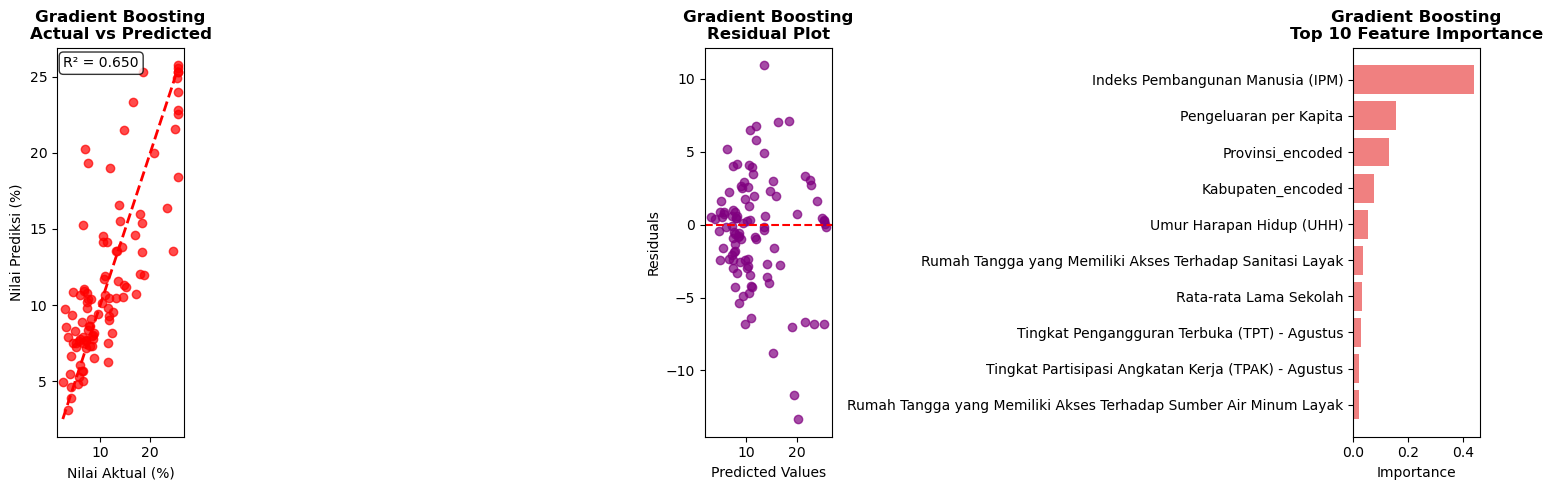

In [38]:
# Visualisasi Gradient Boosting
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_test_gb, alpha=0.7, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Nilai Aktual (%)')
plt.ylabel('Nilai Prediksi (%)')
plt.title('Gradient Boosting\nActual vs Predicted', fontweight='bold')
plt.text(0.05, 0.95, f'R² = {test_r2_gb:.3f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.subplot(1, 3, 2)
residuals_gb = y_test - y_pred_test_gb
plt.scatter(y_pred_test_gb, residuals_gb, alpha=0.7, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Gradient Boosting\nResidual Plot', fontweight='bold')

plt.subplot(1, 3, 3)
# Top 10 features
top_features_gb = gb_importance.head(10).sort_values('Importance', ascending=True)
plt.barh(top_features_gb['Feature'], top_features_gb['Importance'], color='lightcoral')
plt.title('Gradient Boosting\nTop 10 Feature Importance', fontweight='bold')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

# Perbandingan Semua Algoritma

In [39]:
comparison_data = {
    'Algorithm': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'Test_R2': [test_r2_lr, test_r2_rf, test_r2_gb],
    'Test_RMSE': [test_rmse_lr, test_rmse_rf, test_rmse_gb],
    'Test_MAE': [test_mae_lr, test_mae_rf, test_mae_gb],
    'CV_R2_Mean': [cv_scores_lr.mean(), cv_scores_rf.mean(), cv_scores_gb.mean()],
    'CV_R2_Std': [cv_scores_lr.std(), cv_scores_rf.std(), cv_scores_gb.std()]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test_R2', ascending=False)

print(comparison_df.round(4))

# Visualisasi Perbandingan
plt.figure(figsize=(15, 10))


           Algorithm  Test_R2  Test_RMSE  Test_MAE  CV_R2_Mean  CV_R2_Std
1      Random Forest   0.6812     3.7005    2.7789      0.2535     0.1100
2  Gradient Boosting   0.6501     3.8771    2.8356      0.1677     0.1599
0  Linear Regression   0.5766     4.2651    3.3570      0.0554     0.3133


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

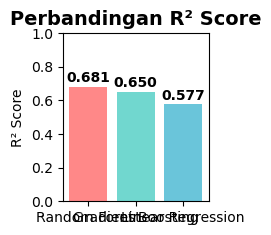

In [40]:
# 1. Perbandingan R² Score
plt.subplot(2, 3, 1)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = plt.bar(comparison_df['Algorithm'], comparison_df['Test_R2'], color=colors, alpha=0.8)
plt.title('Perbandingan R² Score', fontsize=14, fontweight='bold')
plt.ylabel('R² Score')
plt.ylim(0, 1)
for bar, value in zip(bars, comparison_df['Test_R2']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')


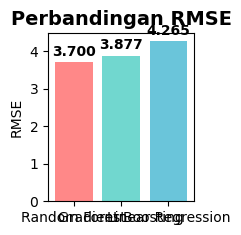

In [41]:
# 2. Perbandingan RMSE
plt.subplot(2, 3, 2)
bars = plt.bar(comparison_df['Algorithm'], comparison_df['Test_RMSE'], color=colors, alpha=0.8)
plt.title('Perbandingan RMSE', fontsize=14, fontweight='bold')
plt.ylabel('RMSE')
for bar, value in zip(bars, comparison_df['Test_RMSE']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')


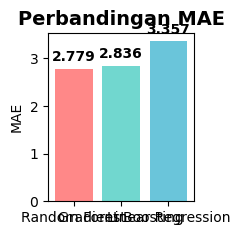

In [42]:
# 3. Perbandingan MAE
plt.subplot(2, 3, 3)
bars = plt.bar(comparison_df['Algorithm'], comparison_df['Test_MAE'], color=colors, alpha=0.8)
plt.title('Perbandingan MAE', fontsize=14, fontweight='bold')
plt.ylabel('MAE')
for bar, value in zip(bars, comparison_df['Test_MAE']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

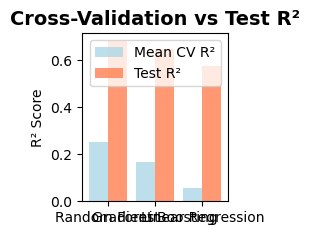

In [43]:
# 4. Cross-Validation Scores
plt.subplot(2, 3, 4)
x_pos = np.arange(len(comparison_df['Algorithm']))
plt.bar(x_pos - 0.2, comparison_df['CV_R2_Mean'], width=0.4, label='Mean CV R²', color='lightblue', alpha=0.8)
plt.bar(x_pos + 0.2, comparison_df['Test_R2'], width=0.4, label='Test R²', color='coral', alpha=0.8)
plt.xticks(x_pos, comparison_df['Algorithm'])
plt.title('Cross-Validation vs Test R²', fontsize=14, fontweight='bold')
plt.ylabel('R² Score')
plt.legend()

In [48]:
# # 5. Feature Importance Comparison (Top 5)
# plt.subplot(2, 3, 5)
# top_features_comparison = pd.DataFrame({
#     'Linear Regression': lr_coefficients.head(5)['Feature'].values,
#     'Random Forest': rf_importance.head(5)['Feature'].values,
#     'Gradient Boosting': gb_importance.head(5)['Feature'].values
# })
# plt.axis('off')
# plt.table(cellText=top_features_comparison.values,
#           rowLabels=['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5'],
#           colLabels=top_features_comparison.columns,
#           cellLoc='center',
#           loc='center',
#           bbox=[0.1, 0.1, 0.9, 0.8])
# plt.title('Top 5 Features Each Algorithm', fontsize=14, fontweight='bold')


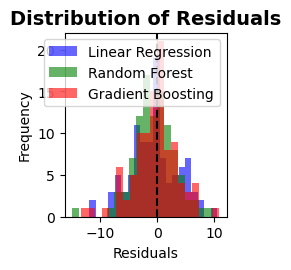

In [45]:
# 6. Residual Distribution
plt.subplot(2, 3, 6)
residuals_all = [residuals_lr, residuals_rf, residuals_gb]
labels = ['Linear Regression', 'Random Forest', 'Gradient Boosting']
colors_residuals = ['blue', 'green', 'red']

for i, (residual, label, color) in enumerate(zip(residuals_all, labels, colors_residuals)):
    plt.hist(residual, alpha=0.6, label=label, color=color, bins=20)

plt.axvline(x=0, color='black', linestyle='--')
plt.title('Distribution of Residuals', fontsize=14, fontweight='bold')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
print("\n" + "="*70)
print("KESIMPULAN AKHIR")
print("="*70)

best_algorithm = comparison_df.iloc[0]
print(f"ALGORITMA TERBAIK: {best_algorithm['Algorithm']}")
print(f"R2 Score: {best_algorithm['Test_R2']:.4f}")
print(f"RMSE: {best_algorithm['Test_RMSE']:.4f}")
print(f"MAE: {best_algorithm['Test_MAE']:.4f}")
print(f"Cross-Validation R2: {best_algorithm['CV_R2_Mean']:.4f}")

print(f"\nINTERPRETASI:")
print(f"- Model {best_algorithm['Algorithm']} dapat menjelaskan {best_algorithm['Test_R2']*100:.2f}% variasi dalam data kemiskinan")
print(f"- Rata-rata error prediksi: ±{best_algorithm['Test_RMSE']:.2f}%")
print(f"- Error absolut rata-rata: {best_algorithm['Test_MAE']:.2f}%")


KESIMPULAN AKHIR
ALGORITMA TERBAIK: Random Forest
R2 Score: 0.6812
RMSE: 3.7005
MAE: 2.7789
Cross-Validation R2: 0.2535

INTERPRETASI:
- Model Random Forest dapat menjelaskan 68.12% variasi dalam data kemiskinan
- Rata-rata error prediksi: ±3.70%
- Error absolut rata-rata: 2.78%
